In [1]:
import os
import re
from collections import defaultdict as df
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
poems = []
ic = 0
for fn in os.listdir("/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/archive"):
    with open("/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/archive/" + fn, 'r') as kf:
        ekkav = kf.read().strip().split('\n')[2:-1]
        for i in range(len(ekkav)):
            if ekkav[i][0] == ' ': ekkav[i] = '<sep>'
        ekkav = '\n'.join(ekkav).split('<sep>')
        for i in range(len(ekkav)):
            if len(ekkav[i]) > 0:
                x = ekkav[i]
                for i in ",.|\'\"":
                    x = x.replace(i, '')
                a = x.strip().split('\n')
                for j in range(0, len(a), 4):
                    x = a[j:j+4]
                    if len(x) == 4:
                        poems.append((' <sep> '.join(x) + ' <sep>').split())


In [4]:
len(poems)

48928

In [5]:
poems = poems[:5000]

In [6]:
vocab = df(int)
for p in poems:
    for w in p: vocab[w]+=1

In [7]:
vocab_size = len(vocab)

In [8]:
vocab_size

2702

In [9]:
tokenizer = {w:i+1 for i,w in enumerate(vocab.keys())}

In [10]:
idx_to_word = {v:k for k,v in tokenizer.items()}

In [11]:
input_sequences = []
for line in poems:
	token_list = [tokenizer[w] for w in line]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)
  
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=vocab_size + 1)

In [12]:
print([idx_to_word[w] for w in predictors[4] if w in idx_to_word],idx_to_word[np.argmax(label[4])])
print(poems[0][:6])

['धूप', 'बहुत', 'है', 'मौसम', 'जल'] थल
['धूप', 'बहुत', 'है', 'मौसम', 'जल', 'थल']


In [13]:
import requests

In [14]:
with open('cc.hi.300.vec.gz', 'wb') as hv:
    hv.write(requests.get("http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz").content)
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
# https://fasttext.cc/docs/en/crawl-vectors.html

In [15]:
import gzip

In [16]:
import shutil
with gzip.open("/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindi-poetry-AI-master/cc.hi.300.vec.gz", 'rb') as f_in:
    with open("/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindi-poetry-AI-master/cc.hi.300.vec", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [19]:
def read_in_chunks(file_object, chunk_size=10*1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 10k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

embedding_matrix = np.zeros((vocab_size + 1, 300))

with open('/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindi-poetry-AI-master/cc.hi.300.vec', 'r') as ff:
    for piece in read_in_chunks(ff):
        for j in piece.split('\n'):
            data = j.split()
            if len(data) == 301:  # Check if line has 301 elements (word + 300-dimensional vector)
                if data[0] in tokenizer:
                    embedding_matrix[tokenizer[data[0]]] = np.array(data[1:], dtype=float)  # Use `float` instead of `np.float`


In [20]:
len(embedding_matrix[5])

300

In [21]:
import pickle
with open('embedding_matrix_32.pkl','wb') as f:
    pickle.dump(embedding_matrix, f)

In [22]:
with open("/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindi-poetry-AI-master/w2i_32.pkl", 'wb') as p:
    pickle.dump(tokenizer, p)

In [23]:
with open("/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindi-poetry-AI-master/i2w_32.pkl", 'wb') as p:
    pickle.dump(idx_to_word, p)

In [26]:
model = Sequential()
model.add(Embedding(vocab_size + 1, 300, input_length=max_sequence_len - 1, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(vocab_size // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(vocab_size + 1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [27]:
model.build(input_shape=(None, max_sequence_len - 1))
print(model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 43, 300)        │       810,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 43, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1351)           │       347,207 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2703)           │     3,654,456 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,382,931 (20.53 MB)

 Trainable params: 4,572,031 (17.44 MB)

 Non-trainable params: 810,900 (3.09 MB)

None


Epoch 1/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 255s 54ms/step - accuracy: 0.1441 - loss: 6.0483
Epoch 2/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 273s 58ms/step - accuracy: 0.2442 - loss: 4.4134
Epoch 3/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 276s 59ms/step - accuracy: 0.5909 - loss: 2.3811
Epoch 4/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 285s 61ms/step - accuracy: 0.8050 - loss: 1.3643
Epoch 5/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 287s 61ms/step - accuracy: 0.8828 - loss: 0.9363


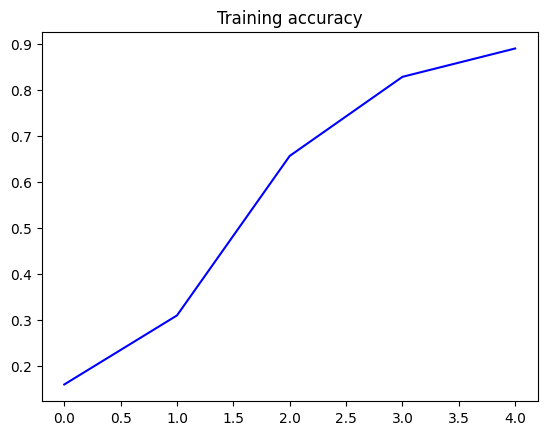

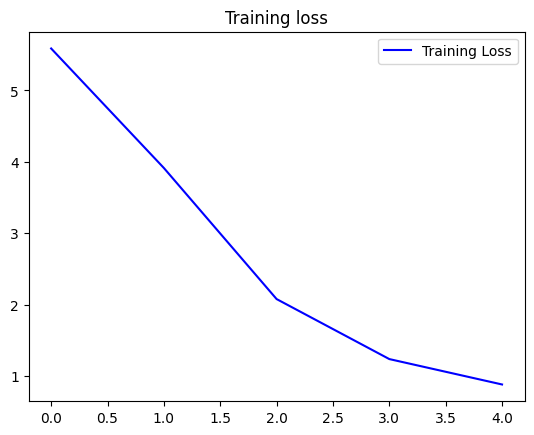

In [28]:
history = model.fit(predictors, label, epochs=5, verbose=1)
model.save('/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindipoet32_5.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Epoch 1/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 268s 57ms/step - accuracy: 0.9139 - loss: 0.7243
Epoch 2/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 274s 58ms/step - accuracy: 0.9269 - loss: 0.6229
Epoch 3/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 292s 62ms/step - accuracy: 0.9285 - loss: 0.5850
Epoch 4/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 299s 64ms/step - accuracy: 0.9390 - loss: 0.5208
Epoch 5/5
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 302s 64ms/step - accuracy: 0.9478 - loss: 0.4615


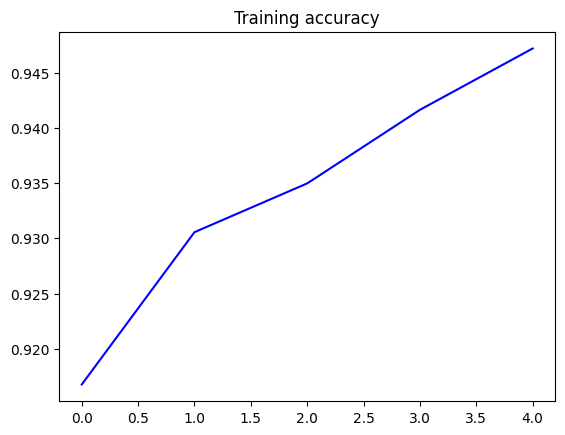

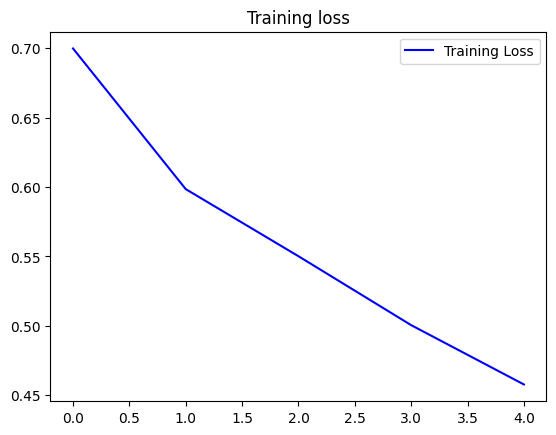

In [29]:
history = model.fit(predictors, label, epochs=5, verbose=1)
model.save('/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindipoet32_10.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Epoch 1/2
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 332s 71ms/step - accuracy: 0.9558 - loss: 0.3936
Epoch 2/2
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 314s 67ms/step - accuracy: 0.9550 - loss: 0.3813


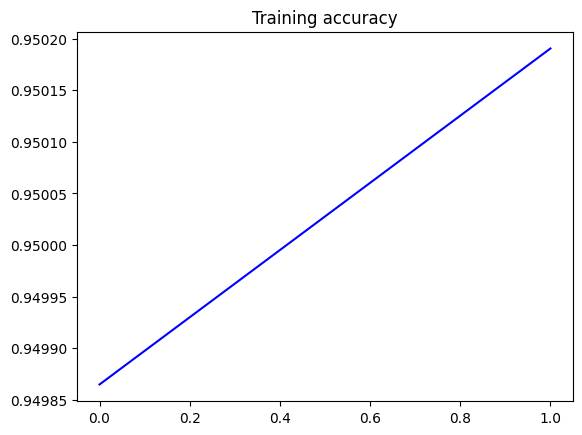

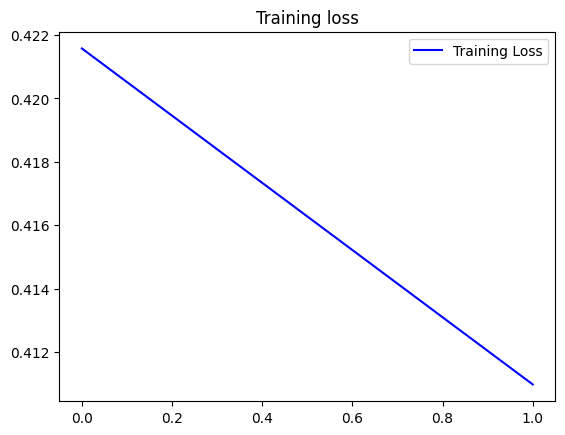

In [31]:
history = model.fit(predictors, label, epochs=2, verbose=1)
model.save('/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindipoet32_12.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [33]:
model = tf.keras.models.load_model('/Users/ganeshsapani/Documents/venv/jupyter notebook/AI hindi poetry generator/hindipoet32_10.h5')

In [34]:
def gen_poem(model, length, w2i, i2w, start = ' ', lines = 4):
    ipseq = [w2i[s] for s in start if s in w2i]
    # print(ipseq)
    lsc = 0 
    while lsc<lines:
        ip = np.array(pad_sequences([ipseq], maxlen=length, padding='pre'))
        # print(ip)
        w = model.predict(ip)[0]
        w = np.argmax(w)
        if i2w[w].strip() == '<sep>':
            lsc+=1
        start+=' '+ i2w[w] 
        ipseq.append(w)
    for i in start.split('<sep>'):
        print(i.strip(), end=  '\n\n')

In [45]:
def gen_poem_random(model, length, w2i, i2w, start=' ', lines=4):
    ipseq = [w2i[s] for s in start if s in w2i]
    # print(ipseq)
    lsc = 0 
    while lsc < lines:
        ip = np.array(pad_sequences([ipseq], maxlen=length, padding='pre'))
        # print(ip)
        w = model.predict(ip)[0]
        w = np.random.choice(np.arange(vocab_size + 1), p=w)
        if w == 0 or w == w2i.get('', 0):  # Use .get() with a default value
            w += 1
        if i2w[w].strip() == '<sep>':
            lsc += 1
        start += ' ' + i2w[w]
        ipseq.append(w)
    for i in start.split('<sep>'):
        print(i.strip(), end='\n\n')


In [44]:
gen_poem(model, max_sequence_len-1, tokenizer, idx_to_word, "बादल", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━

In [46]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "दुनिया को छोड़ना चाहा", 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
दुनिया को छोड़ना चाहा शरारत सारी ज़माना बहुत ने आँखें लहू में 

In [47]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "दुनिया को छोड़ना चाहा", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
दुनिया को छोड़ना चाहा बिछड़ा कि हैं

यहाँ तुम दावेदार और

तो दीवारों से पूछते हम तुम

तुम्हार

In [48]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "तुम्हें समुंदर में छोड़ना", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
तुम्हें समुंदर में छोड़ना है हाल ने शहद कहा

गुम बाँटने और जब पर सवार में



के ख़्वाब दुश्मन पत्थर छोड़ जीत हूँ





In [49]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "मेरा ज़माना", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
मेरा ज़माना है कम-ओ-ब

In [50]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "हाथी-घोड़े", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [51]:
gen_poem(model, max_sequence_len-1, tokenizer, idx_to_word, "सस्ती जन्नत", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
सस्ती जन्नत मसीहा क्या जाने

ज़ख़्म है या गहराई है

वाह रे पागल वाह रे दिल

अच्छी किसमत पाई है





In [52]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "हाथी-घोड़े", 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
हाथी-घोड़े एक सूरज ने सफ़र भर है

यहाँ हिस्से भी न रक्खा था





In [53]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "ग़ैर-ज़रूरी लोग ज़िंदगी किस तरह गुज़ारते हैं", 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [54]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "ग़ैर-ज़रूरी लोग", 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━